# Setup and Imports

In [17]:
!pip install "numpy<2"

In [1]:
!pip install scikit-learn-extra -q

# Clustering algorithms
from sklearn_extra.cluster import KMedoids

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, BisectingKMeans

# Hierarchy for Dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

# Evaluation metrics
from sklearn.metrics import (
    rand_score,
    adjusted_rand_score,
    mutual_info_score,
    adjusted_mutual_info_score,
    normalized_mutual_info_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


# Load Datasets

In [3]:
pip install ucimlrepo

In [4]:
# Load Iris Dataset
from ucimlrepo import fetch_ucirepo
iris = fetch_ucirepo(id=53)
X_iris, y_iris = iris.data.features, iris.data.targets
# Get number of clusters for Iris
k_iris = len(np.unique(y_iris))
print(f"Iris dataset loaded: {X_iris.shape[0]} samples, {X_iris.shape[1]} features, {k_iris} classes.")

# Load Wine Dataset
wine = fetch_ucirepo(id=109)
X_wine, y_wine = wine.data.features, wine.data.targets
# Get number of clusters for Wine
k_wine = len(np.unique(y_wine))
print(f"Wine dataset loaded: {X_wine.shape[0]} samples, {X_wine.shape[1]} features, {k_wine} classes.")

Iris dataset loaded: 150 samples, 4 features, 3 classes.
Wine dataset loaded: 178 samples, 13 features, 3 classes.


# Preprocessing and Helper Functions

## Data Scaling

In [5]:
scaler = StandardScaler()

# Scale Iris data
X_iris_scaled = scaler.fit_transform(X_iris)

# Scale Wine data
X_wine_scaled = scaler.fit_transform(X_wine)

print("Data scaled.")

Data scaled.


## SSE and SSB Helper Functions

In [6]:
def get_cluster_centers(X, labels):
    """Calculates centroids for clusters."""
    n_clusters = len(np.unique(labels))
    # Handle noise points in DBSCAN/OPTICS (often labeled -1)
    if -1 in labels:
        n_clusters -= 1

    centers = []
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            centers.append(cluster_points.mean(axis=0))
    return np.array(centers)

def calculate_sse(X, labels, centers):
    """Calculates Sum of Squared Error (Cohesion)."""
    sse = 0
    n_clusters = len(centers)

    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            distances = np.sum((cluster_points - centers[i])**2, axis=1)
            sse += np.sum(distances)
    return sse

def calculate_ssb(X, labels, centers):
    """Calculates Sum of Squares Between (Separation)."""
    ssb = 0
    global_mean = X.mean(axis=0)
    n_clusters = len(centers)

    for i in range(n_clusters):
        cluster_points = X[labels == i]
        n_points = len(cluster_points)
        if n_points > 0:
            ssb += n_points * np.sum((centers[i] - global_mean)**2)
    return ssb

print("Helper functions defined.")

Helper functions defined.


# Analysis: Iris Dataset

## Hierarchical Clustering (Dendrogram)

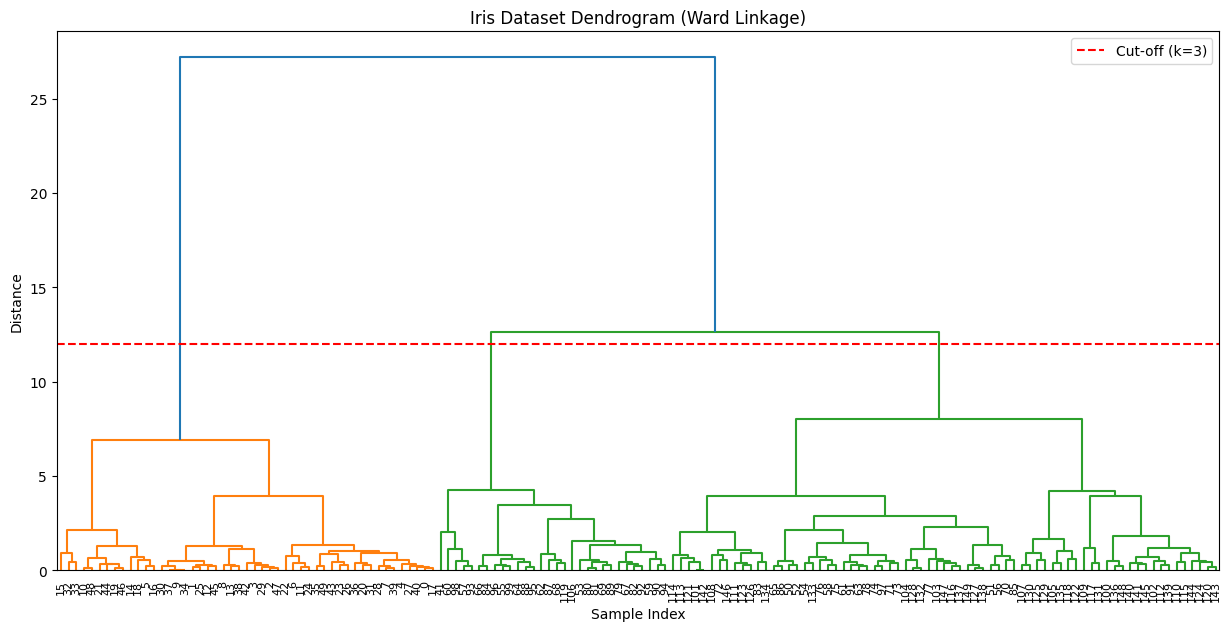

In [7]:
plt.figure(figsize=(15, 7))
plt.title("Iris Dataset Dendrogram (Ward Linkage)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")

# Perform hierarchical clustering to get the linkage matrix
linked_iris = linkage(X_iris_scaled, method='ward')

# Plot the dendrogram
dendrogram(linked_iris,
           leaf_rotation=90.,  # rotates the x axis labels
           leaf_font_size=8.,  # font size for the x axis labels
          )
plt.axhline(y=12, color='r', linestyle='--', label='Cut-off (k=3)')
plt.legend()
plt.show()

## Algorithm Application and Evaluation (Iris)

In [8]:
# We fix the random_state for reproducible results
random_state = 42

# --- Define Models ---
models_iris = {
    # Partition-based
    'K-means': KMeans(n_clusters=k_iris, n_init=10, random_state=random_state),
    'K-medoids (PAM)': KMedoids(n_clusters=k_iris, random_state=random_state),
    'K-means++': KMeans(n_clusters=k_iris, init='k-means++', n_init=10, random_state=random_state),
    'Bisecting K-means': BisectingKMeans(n_clusters=k_iris, n_init=10, random_state=random_state),

    # Hierarchical
    'Agglomerative': AgglomerativeClustering(n_clusters=k_iris),

    # Density-based
    'DBSCAN': DBSCAN(eps=0.8, min_samples=5),
    'OPTICS': OPTICS(min_samples=5)
}

# --- Evaluate Models ---
results_iris = []

for name, model in models_iris.items():
    # Fit model and get labels
    model.fit(X_iris_scaled)

    # Handle labels from different models
    if hasattr(model, 'labels_'):
        labels = model.labels_
    else:
        labels = model.predict(X_iris_scaled)

    # --- Get Metrics ---

    # Handle cases where DBSCAN/OPTICS find only 1 cluster or noise (-1)
    # These metrics require at least 2 cluster labels
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2 or (len(unique_labels) == 2 and -1 in unique_labels):
        print(f"Skipping internal metrics for {name}: Not enough clusters found (labels: {unique_labels}).")
        silhouette = np.nan
        calinski = np.nan
        davies = np.nan
        sse = np.nan
        ssb = np.nan
    else:
        # Internal Metrics
        silhouette = silhouette_score(X_iris_scaled, labels)
        calinski = calinski_harabasz_score(X_iris_scaled, labels)
        davies = davies_bouldin_score(X_iris_scaled, labels)

        # Cohesion/Separation Metrics
        # Get centers (provided by model or calculated)
        if hasattr(model, 'cluster_centers_'):
            centers = model.cluster_centers_
        else:
            centers = get_cluster_centers(X_iris_scaled, labels)

        sse = calculate_sse(X_iris_scaled, labels, centers)
        ssb = calculate_ssb(X_iris_scaled, labels, centers)

    # External Metrics (vs. y_iris)
    # Flatten y_iris to a 1D array
    y_iris_flat = y_iris.values.ravel()

    ri = rand_score(y_iris_flat, labels)
    ari = adjusted_rand_score(y_iris_flat, labels)
    mi = mutual_info_score(y_iris_flat, labels)
    ami = adjusted_mutual_info_score(y_iris_flat, labels)
    nmi = normalized_mutual_info_score(y_iris_flat, labels)

    results_iris.append({
        'Algorithm': name,
        'Category': 'Partition-based' if name in ['K-means', 'K-medoids (PAM)', 'K-means++', 'Bisecting K-means']
                    else 'Hierarchical' if name == 'Agglomerative'
                    else 'Density-based',
        'ARI': ari,
        'NMI': nmi,
        'RI': ri,
        'AMI': ami,
        'MI': mi,
        'Silhouette': silhouette,
        'Calinski-Harabasz': calinski,
        'Davies-Bouldin': davies,
        'SSE (Cohesion)': sse,
        'SSB (Separation)': ssb
    })

# Create DataFrame for results
df_iris = pd.DataFrame(results_iris)

## Performance Comparison Tables (Iris)

### Partition-based Clustering (Iris)

In [9]:
print("--- Iris: Partition-based Results ---")
df_partition_iris = df_iris[df_iris['Category'] == 'Partition-based'].set_index('Algorithm')
# Select only numeric columns for formatting
numeric_cols = df_partition_iris.select_dtypes(include=np.number).columns
display(df_partition_iris.style.format({col: "{:.3f}" for col in numeric_cols}).background_gradient(cmap='viridis', axis=0))

--- Iris: Partition-based Results ---


,Category,ARI,NMI,RI,AMI,MI,Silhouette,Calinski-Harabasz,Davies-Bouldin,SSE (Cohesion),SSB (Separation)
Algorithm,,,,,,,,,,,
K-means,Partition-based,0.620,0.659,0.832,0.655,0.724,0.459,239.342,0.835,140.966,459.034
K-medoids (PAM),Partition-based,0.631,0.669,0.837,0.665,0.733,0.458,237.131,0.841,149.682,457.667
K-means++,Partition-based,0.620,0.659,0.832,0.655,0.724,0.459,239.342,0.835,140.966,459.034
Bisecting K-means,Partition-based,0.610,0.653,0.828,0.648,0.717,0.458,239.336,0.836,140.968,459.032


### Hierarchical Clustering (Iris)

In [10]:
print("\n--- Iris: Hierarchical Results ---")
df_hierarchical_iris = df_iris[df_iris['Category'] == 'Hierarchical'].set_index('Algorithm')
# Select only numeric columns for formatting
numeric_cols = df_hierarchical_iris.select_dtypes(include=np.number).columns
display(df_hierarchical_iris.style.format({col: "{:.3f}" for col in numeric_cols}).background_gradient(cmap='viridis', axis=0))


--- Iris: Hierarchical Results ---


,Category,ARI,NMI,RI,AMI,MI,Silhouette,Calinski-Harabasz,Davies-Bouldin,SSE (Cohesion),SSB (Separation)
Algorithm,,,,,,,,,,,
Agglomerative,Hierarchical,0.615,0.675,0.825,0.671,0.723,0.446,220.260,0.806,150.122,449.878


### Density-based Clustering (Iris)

In [11]:
print("\n--- Iris: Density-based Results ---")
df_density_iris = df_iris[df_iris['Category'] == 'Density-based'].set_index('Algorithm')
# Select only numeric columns for formatting
numeric_cols = df_density_iris.select_dtypes(include=np.number).columns
display(df_density_iris.style.format({col: "{:.3f}" for col in numeric_cols}).background_gradient(cmap='viridis', axis=0))


--- Iris: Density-based Results ---


,Category,ARI,NMI,RI,AMI,MI,Silhouette,Calinski-Harabasz,Davies-Bouldin,SSE (Cohesion),SSB (Separation)
Algorithm,,,,,,,,,,,
DBSCAN,Density-based,0.552,0.690,0.772,0.685,0.636,0.521,124.986,1.940,191.394,365.435
OPTICS,Density-based,0.051,0.292,0.512,0.266,0.308,-0.298,8.227,2.451,3.628,128.626


# Analysis: Wine Dataset

## Hierarchical Clustering (Dendrogram)

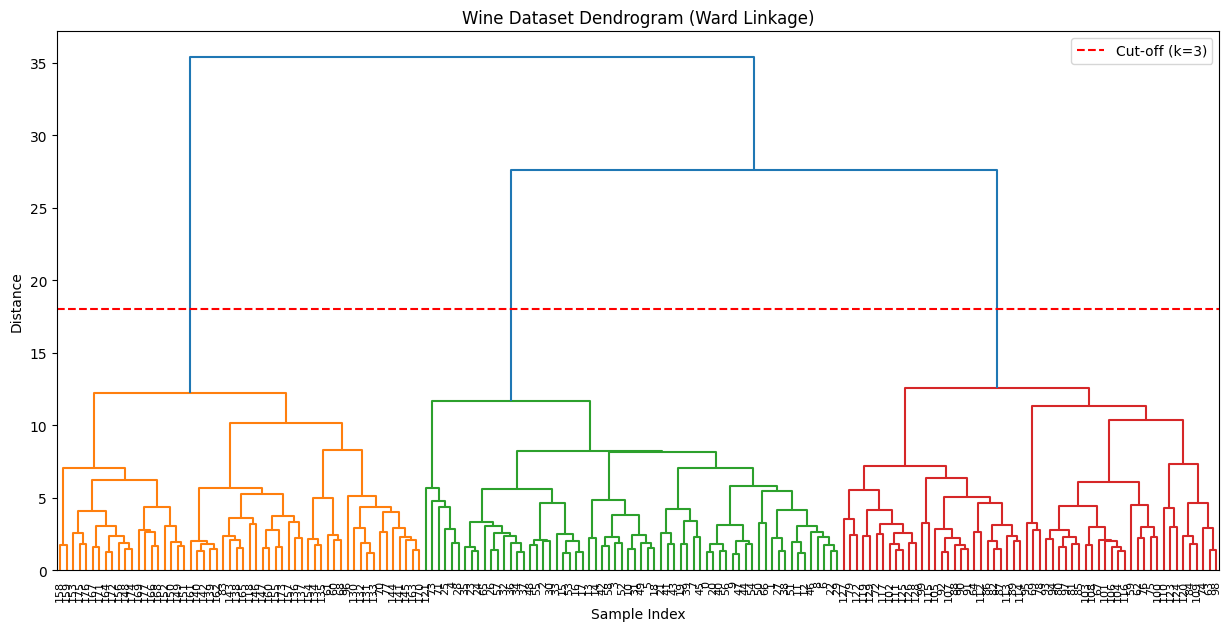

In [12]:
plt.figure(figsize=(15, 7))
plt.title("Wine Dataset Dendrogram (Ward Linkage)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")

# Perform hierarchical clustering
linked_wine = linkage(X_wine_scaled, method='ward')

# Plot the dendrogram
dendrogram(linked_wine,
           leaf_rotation=90.,
           leaf_font_size=8.,
          )
plt.axhline(y=18, color='r', linestyle='--', label='Cut-off (k=3)')
plt.legend()
plt.show()

## Algorithm Application and Evaluation (Wine)

In [13]:
# --- Define Models ---
models_wine = {
    # Partition-based
    'K-means': KMeans(n_clusters=k_wine, n_init=10, random_state=random_state),
    'K-medoids (PAM)': KMedoids(n_clusters=k_wine, random_state=random_state),
    'K-means++': KMeans(n_clusters=k_wine, init='k-means++', n_init=10, random_state=random_state),
    'Bisecting K-means': BisectingKMeans(n_clusters=k_wine, n_init=10, random_state=random_state),

    # Hierarchical
    'Agglomerative': AgglomerativeClustering(n_clusters=k_wine),

    # Density-based
    'DBSCAN': DBSCAN(eps=1.5, min_samples=5),
    'OPTICS': OPTICS(min_samples=5, xi=0.03) # Tuned xi for cluster extraction
}

# --- Evaluate Models ---
results_wine = []

for name, model in models_wine.items():
    # Fit model and get labels
    model.fit(X_wine_scaled)

    if hasattr(model, 'labels_'):
        labels = model.labels_
    else:
        labels = model.predict(X_wine_scaled)

    # --- Get Metrics ---
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2 or (len(unique_labels) == 2 and -1 in unique_labels):
        print(f"Skipping internal metrics for {name}: Not enough clusters found (labels: {unique_labels}).")
        silhouette = np.nan
        calinski = np.nan
        davies = np.nan
        sse = np.nan
        ssb = np.nan
    else:
        # Internal Metrics
        silhouette = silhouette_score(X_wine_scaled, labels)
        calinski = calinski_harabasz_score(X_wine_scaled, labels)
        davies = davies_bouldin_score(X_wine_scaled, labels)

        # Cohesion/Separation
        if hasattr(model, 'cluster_centers_'):
            centers = model.cluster_centers_
        else:
            centers = get_cluster_centers(X_wine_scaled, labels)

        sse = calculate_sse(X_wine_scaled, labels, centers)
        ssb = calculate_ssb(X_wine_scaled, labels, centers)

    # External Metrics
    # Flatten y_wine to a 1D array
    y_wine_flat = y_wine.values.ravel()

    ri = rand_score(y_wine_flat, labels)
    ari = adjusted_rand_score(y_wine_flat, labels)
    mi = mutual_info_score(y_wine_flat, labels)
    ami = adjusted_mutual_info_score(y_wine_flat, labels)
    nmi = normalized_mutual_info_score(y_wine_flat, labels)

    results_wine.append({
        'Algorithm': name,
        'Category': 'Partition-based' if name in ['K-means', 'K-medoids (PAM)', 'K-means++', 'Bisecting K-means']
                    else 'Hierarchical' if name == 'Agglomerative'
                    else 'Density-based',
        'ARI': ari,
        'NMI': nmi,
        'RI': ri,
        'AMI': ami,
        'MI': mi,
        'Silhouette': silhouette,
        'Calinski-Harabasz': calinski,
        'Davies-Bouldin': davies,
        'SSE (Cohesion)': sse,
        'SSB (Separation)': ssb
    })

# Create DataFrame for results
df_wine = pd.DataFrame(results_wine)

Skipping internal metrics for DBSCAN: Not enough clusters found (labels: [-1]).


## Performance Comparison Tables (Wine)

### Partition-based Clustering (Wine)

In [14]:
print("--- Wine: Partition-based Results ---")
df_partition_wine = df_wine[df_wine['Category'] == 'Partition-based'].set_index('Algorithm')
# Select only numeric columns for formatting
numeric_cols = df_partition_wine.select_dtypes(include=np.number).columns
display(df_partition_wine.style.format({col: "{:.3f}" for col in numeric_cols}).background_gradient(cmap='viridis', axis=0))

--- Wine: Partition-based Results ---


,Category,ARI,NMI,RI,AMI,MI,Silhouette,Calinski-Harabasz,Davies-Bouldin,SSE (Cohesion),SSB (Separation)
Algorithm,,,,,,,,,,,
K-means,Partition-based,0.897,0.876,0.954,0.875,0.954,0.285,70.940,1.389,1277.928,1036.072
K-medoids (PAM),Partition-based,0.726,0.757,0.877,0.754,0.821,0.266,66.752,1.416,1564.606,1258.524
K-means++,Partition-based,0.897,0.876,0.954,0.875,0.954,0.285,70.940,1.389,1277.928,1036.072
Bisecting K-means,Partition-based,0.706,0.742,0.869,0.739,0.809,0.268,66.395,1.429,1315.673,998.327


### Hierarchical Clustering (Wine)

In [15]:
print("\n--- Wine: Hierarchical Results ---")
df_hierarchical_wine = df_wine[df_wine['Category'] == 'Hierarchical'].set_index('Algorithm')
# Select only numeric columns for formatting
numeric_cols = df_hierarchical_wine.select_dtypes(include=np.number).columns
display(df_hierarchical_wine.style.format({col: "{:.3f}" for col in numeric_cols}).background_gradient(cmap='viridis', axis=0))


--- Wine: Hierarchical Results ---


,Category,ARI,NMI,RI,AMI,MI,Silhouette,Calinski-Harabasz,Davies-Bouldin,SSE (Cohesion),SSB (Separation)
Algorithm,,,,,,,,,,,
Agglomerative,Hierarchical,0.790,0.786,0.906,0.784,0.858,0.277,67.647,1.419,1305.049,1008.951


### Density-based Clustering (Wine)

In [16]:
print("\n--- Wine: Density-based Results ---")
df_density_wine = df_wine[df_wine['Category'] == 'Density-based'].set_index('Algorithm')
# Select only numeric columns for formatting
numeric_cols = df_density_wine.select_dtypes(include=np.number).columns
display(df_density_wine.style.format({col: "{:.3f}" for col in numeric_cols}).background_gradient(cmap='viridis', axis=0))


--- Wine: Density-based Results ---


,Category,ARI,NMI,RI,AMI,MI,Silhouette,Calinski-Harabasz,Davies-Bouldin,SSE (Cohesion),SSB (Separation)
Algorithm,,,,,,,,,,,
DBSCAN,Density-based,0.000,0.000,0.338,0.000,0.000,nan,nan,nan,nan,nan
OPTICS,Density-based,0.071,0.280,0.508,0.251,0.287,-0.103,5.883,1.627,80.658,358.317
